# NLP Sentiment Analysis of Yelp Data

Importing relevant libraries

In [1]:
import numpy as num
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn as skl
import xgboost
import gensim
import json
import re
import string
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, recall_score

In [2]:
trainingAmount = 40000
validationAmount = int(0.2 * trainingAmount)
testAmount = 10000

# Read JSON files, which are created in 'DatasetPruning' :
df_train = pd.read_json('training' + str(int(trainingAmount-validationAmount))  +'.json', lines=True)
df_validation = pd.read_json('validation' + str(validationAmount) +'.json', lines = True)
df_test = pd.read_json('test' + str(testAmount) +'.json', lines=True)

# Reorder the columns of JSON files:
df_train = df_train.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_train = df_train.reindex(['text','stars','useful','funny','cool'], axis=1)

df_validation = df_validation.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_validation = df_validation.reindex(['text','stars','useful','funny','cool'], axis=1)

df_test = df_test.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_test = df_test.reindex(['text','stars','useful','funny','cool'], axis=1)



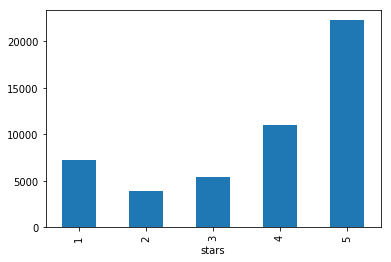

In [3]:
frames = [df_train, df_validation, df_test]
df_train_validation_test = pd.concat(frames)
df_train_validation_test.groupby("stars")['stars'].count().plot.bar()

## Defining the clean method

In [4]:
def clean(text):
    from nltk.stem import WordNetLemmatizer
    from nltk.stem.snowball import SnowballStemmer
    from nltk.tokenize import word_tokenize
    
     # Empty question
    if type(text) != str:
        return ''
    
    text = text.lower()
    
    # removing all punctuation
    text = re.sub('[' + string.punctuation + ']', ' ', text)
    
    # frequent spelling mistakes
    text = re.sub('im', "", text)

    
    #Tokenizing text for normalizing more easily
    tokenized_text = word_tokenize(text)
    
    
    
    #Removing stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    kept_words = ['he', 'she', 'they', 'we']
    for kw in kept_words:
        stopwords.remove(kw)
    
    tokenized_text = [w for w in tokenized_text if not w in stopwords] 
    
    
    #Removing numbers
    tokenized_text = [w for w in tokenized_text if w.isalpha()]
    
    
    
    #Putting tokens back together as a string
    text = ''
    for token in tokenized_text:
        text += token + ' '
        
    
    # Return a list of words
    return text

In [5]:
df_test['length'] = df_test['text'].apply(len)
df_validation['length'] = df_validation['text'].apply(len)
df_train['length'] = df_train['text'].apply(len)


In [6]:
df_train.describe()


,stars,useful,funny,cool,length
count,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000
mean,3.741594,1.261562,0.438375,0.538344,582.534000
std,1.452695,2.757854,1.508815,1.902799,541.088638
min,1.000000,0.000000,0.000000,0.000000,2.000000
25%,3.000000,0.000000,0.000000,0.000000,233.000000
50%,4.000000,0.000000,0.000000,0.000000,415.000000
75%,5.000000,1.000000,0.000000,0.000000,739.000000
max,5.000000,91.000000,46.000000,86.000000,5000.000000


Cleaning the data

In [7]:
df_train['cleaned_text'] = df_train['text'].apply(clean)
df_validation['cleaned_text'] = df_validation[ 'text'].apply(clean)
df_test['cleaned_text'] = df_test['text'].apply(clean)


Saving all the necessary data in arrays

In [8]:
train = df_train['cleaned_text'].values
validation = df_validation['cleaned_text'].values
test = df_test['cleaned_text'].values

trainStars = df_train['stars'].values
validationStars = df_validation['stars'].values
testStars = df_test['stars'].values

In [9]:
def show_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm, index = [i for i in "12345"],
                      columns = [i for i in "12345"])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [10]:
def show_confusion_matrix_proportions(cm):
    confusion_matrix_proportions = []
    for n in range(cm.shape[0]):
        confusion_matrix_proportions.append(cm[n,:]/df_test.groupby('stars').count().at[n+1, 'text'])

    confusion_matrix_proportions = num.array(confusion_matrix_proportions)

    df_cm = pd.DataFrame(confusion_matrix_proportions, index = [i for i in "12345"],
                      columns = [i for i in "12345"])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [123]:
def stacked_bar_chart(label, predicted):
    import collections
    distance = num.abs(label - predicted)
    distance_count = collections.Counter(distance)
    print(distance_count)
    p0 = plt.bar(0, distance_nb[0]/100, 3)
    p1 = plt.bar(0, distance_nb[1]/100, 3, bottom=(distance_nb[0])/100)
    p2 = plt.bar(0, distance_nb[2]/100, 3, bottom=(distance_nb[1]+distance_nb[0])/100)
    p3 = plt.bar(0, distance_nb[3]/100, 3, bottom=(distance_nb[2]+distance_nb[1]+distance_nb[0])/100)
    p4 = plt.bar(0, distance_nb[4]/100, 3, bottom=(distance_nb[3]+distance_nb[2]+distance_nb[1]+distance_nb[0])/100)
    plt.ylabel('Percentage of occurrences')
#     plt.title('Error in star rating predicted')
    plt.xticks([])
    plt.yticks(num.arange(0, 110, 10))
    plt.legend((p0, p1, p2, p3, p4), ('0', '1', '2', '3', '4'), loc='lower right', title='Stars')

In [12]:
starProp_test = df_test.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1).drop('cleaned_text', axis=1)
starProp_test['percentage'] = starProp_test['text'] / df_test.shape[0] * 100
starProp_test


,text,percentage
stars,,
1,1424,14.24
2,750,7.50
3,1076,10.76
4,2217,22.17
5,4533,45.33


## BOW model with Naïve Bayes Classifier

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()
trainVecs = vectorizer.fit_transform(train)
testVecs = vectorizer.transform(test)

In [14]:
from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()
classifierNB.fit(trainVecs, trainStars)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
testStars_predicted_nb = classifierNB.predict(testVecs)
print(classifierNB.score(testVecs, testStars)*100, "%")

60.760000000000005 %


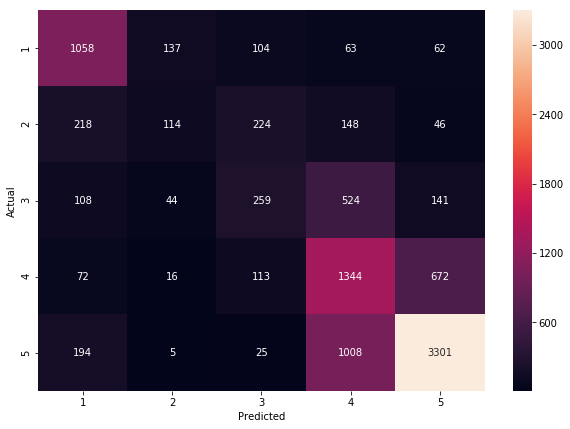

In [16]:
conf_matrix_nb = confusion_matrix(testStars, testStars_predicted_nb, labels=None, sample_weight=None)

show_confusion_matrix(conf_matrix_nb)

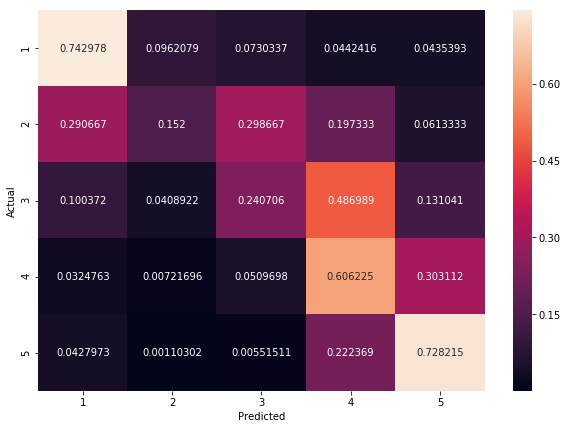

In [17]:
show_confusion_matrix_proportions(conf_matrix_nb)

In [18]:
print(classification_report(testStars, testStars_predicted_nb, digits=5))

              precision    recall  f1-score   support

           1    0.64121   0.74298   0.68835      1424
           2    0.36076   0.15200   0.21388       750
           3    0.35724   0.24071   0.28762      1076
           4    0.43537   0.60622   0.50679      2217
           5    0.78186   0.72822   0.75408      4533

   micro avg    0.60760   0.60760   0.60760     10000
   macro avg    0.51529   0.49402   0.49015     10000
weighted avg    0.60774   0.60760   0.59919     10000



Counter({0: 6076, 1: 2940, 2: 542, 4: 256, 3: 186})


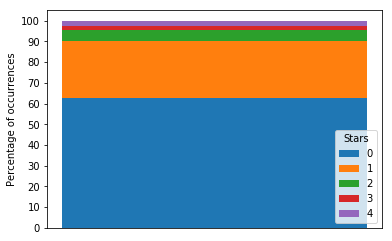

In [124]:
stacked_bar_chart(testStars, testStars_predicted_nb)

In [112]:
recall_score(testStars, testStars_predicted_nb, average='weighted')

0.6076

## Word2Vec model
Tokenizing the words

In [21]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

train_tokenized = [word_tokenize(token) for token in train]
validation_tokenized = [word_tokenize(token) for token in validation]
test_tokenized = [word_tokenize(token) for token in test]
word2vec = Word2Vec(train_tokenized + validation_tokenized, min_count=10) # Vector size left at default value of 100 after experimenting

word2vec.init_sims(replace=True)


In [22]:
def sent2vec(reviewTok):
    vecSize = len(word2vec.wv[reviewTok[0][0]])
    reviewVec = []
    for review in reviewTok:
        vectorSum = num.zeros(vecSize)
        empty = True
        for token in review:
            if token in word2vec.wv.vocab:
                vectorSum += word2vec.wv[token]
                empty = False
        if not empty:
            vectorSum = vectorSum / num.sqrt((vectorSum ** 2).sum())
        reviewVec.append(vectorSum)
    return num.array(reviewVec)

In [23]:
train_vectors = sent2vec(train_tokenized)
validation_vectors = sent2vec(validation_tokenized)
test_vectors = sent2vec(test_tokenized)

### XGBoost classifier

In [24]:
from xgboost import XGBClassifier

best_accuracy = 0
best_regularization = 0

regularizations = num.linspace(0 , 2 ,  5)
accuracies = [ ]

for regularization in regularizations:
    
    xgbclassifier = XGBClassifier(gamma = regularization, eta = 0.03, num_round = 2,  max_depth = 5, tree_method = 'hist' )
    xgbclassifier.fit(train_vectors, trainStars)
    accuracy = xgbclassifier.score(validation_vectors, validationStars)    
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_regularization = regularization

    print('best accuracy:' , best_accuracy )
    print('best regularization parameter (C):' , best_regularization)
    print('----------------------------------------------------')
    
    best_xgbclassifier = XGBClassifier(booster = 'dart', gamma = best_regularization, eta = 0.03, num_round = 2,  max_depth = 5, tree_method = 'hist' )
    best_xgbclassifier.fit(num.vstack((train_vectors, validation_vectors)), num.hstack((trainStars, validationStars))) 


best accuracy: 0.6125
best regularization parameter (C): 0.0
----------------------------------------------------
best accuracy: 0.6125
best regularization parameter (C): 0.0
----------------------------------------------------
best accuracy: 0.6125
best regularization parameter (C): 0.0
----------------------------------------------------
best accuracy: 0.6125
best regularization parameter (C): 0.0
----------------------------------------------------
best accuracy: 0.614
best regularization parameter (C): 2.0
----------------------------------------------------


In [25]:
testStars_predicted_xgb = best_xgbclassifier.predict(test_vectors)
print('Accuracy', best_xgbclassifier.score(test_vectors, testStars)*100, '%')

Accuracy 62.760000000000005 %


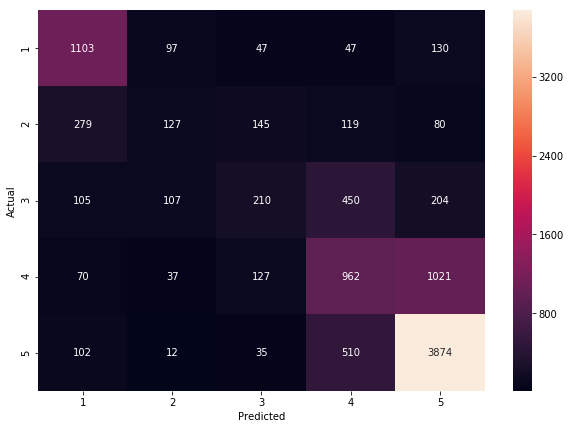

In [26]:
conf_matrix_xgb = confusion_matrix(testStars, testStars_predicted_xgb, labels=None, sample_weight=None)

show_confusion_matrix(conf_matrix_xgb)

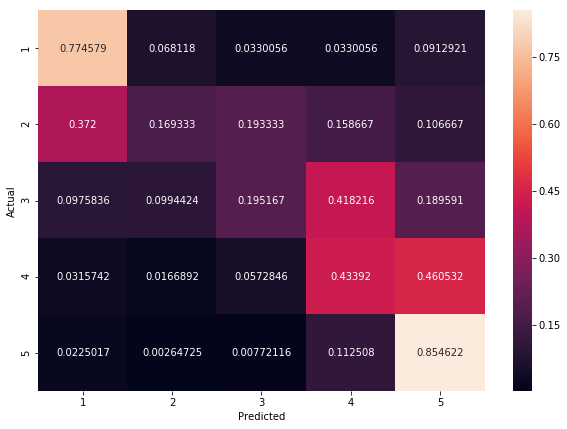

In [27]:
show_confusion_matrix_proportions(conf_matrix_xgb)

In [28]:
print(classification_report(testStars, testStars_predicted_xgb, digits=5))

              precision    recall  f1-score   support

           1    0.66486   0.77458   0.71554      1424
           2    0.33421   0.16933   0.22478       750
           3    0.37234   0.19517   0.25610      1076
           4    0.46073   0.43392   0.44692      2217
           5    0.72970   0.85462   0.78724      4533

   micro avg    0.62760   0.62760   0.62760     10000
   macro avg    0.51237   0.48552   0.48611     10000
weighted avg    0.59272   0.62760   0.60224     10000



Counter({0: 6276, 1: 2736, 2: 547, 4: 232, 3: 209})


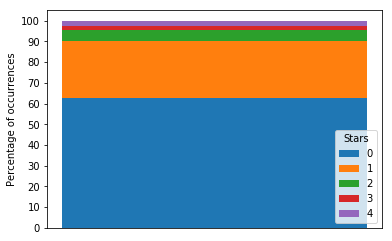

In [125]:
stacked_bar_chart(testStars, testStars_predicted_xgb)

In [113]:
recall_score(testStars, testStars_predicted_xgb, average='weighted')

0.6276

### Support Vector  Machine classifier

In [31]:
from sklearn.svm import SVC

best_accuracy = 0
best_regularization = 0

regularizations = num.linspace(1, 2, 5)
accuracies = []

for regularization in regularizations:
    
    svc = SVC(gamma= 'auto', C= regularization)
    svc.fit(train_vectors, trainStars)
    accuracy = svc.score(validation_vectors, validationStars)    
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_regularization = regularization
    
  
    print('best accuracy:' , best_accuracy )
    print('best regularization parameter (C):', best_regularization)
    print('----------------------------------------------------')
    
    best_svc = SVC( gamma= 'auto', C = best_regularization)
    best_svc.fit(num.vstack((train_vectors, validation_vectors)), num.hstack((trainStars, validationStars))) 
    

best accuracy: 0.602875
best regularization parameter (C): 1.0
----------------------------------------------------
best accuracy: 0.60625
best regularization parameter (C): 1.25
----------------------------------------------------
best accuracy: 0.609625
best regularization parameter (C): 1.5
----------------------------------------------------
best accuracy: 0.6105
best regularization parameter (C): 1.75
----------------------------------------------------
best accuracy: 0.611375
best regularization parameter (C): 2.0
----------------------------------------------------


In [32]:
testStars_predicted_svc = best_svc.predict(test_vectors)
print('Accuracy', best_svc.score(test_vectors, testStars)*100, '%')

Accuracy 62.93 %


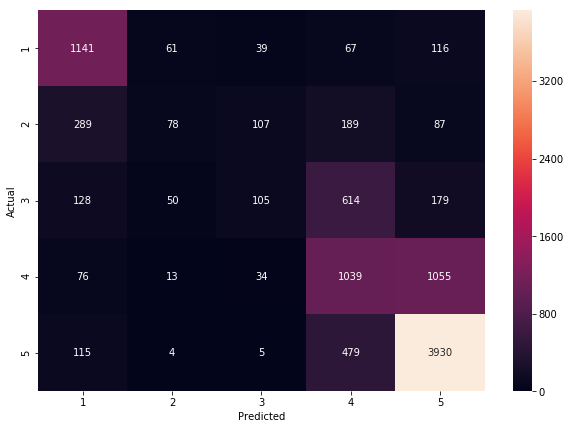

In [33]:
conf_matrix_svc = confusion_matrix(testStars, testStars_predicted_svc, labels=None, sample_weight=None)

show_confusion_matrix(conf_matrix_svc)

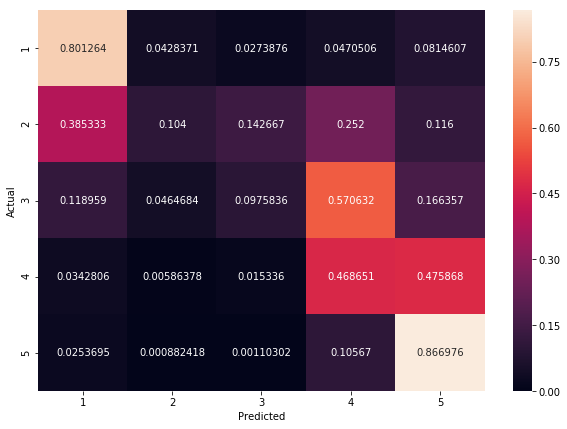

In [34]:
show_confusion_matrix_proportions(conf_matrix_svc)

In [35]:
print(classification_report(testStars, testStars_predicted_svc, digits=5))

              precision    recall  f1-score   support

           1    0.65237   0.80126   0.71919      1424
           2    0.37864   0.10400   0.16318       750
           3    0.36207   0.09758   0.15373      1076
           4    0.43509   0.46865   0.45125      2217
           5    0.73225   0.86698   0.79394      4533

   micro avg    0.62930   0.62930   0.62930     10000
   macro avg    0.51209   0.46769   0.45626     10000
weighted avg    0.58864   0.62930   0.59113     10000



Counter({0: 6293, 1: 2689, 2: 553, 3: 234, 4: 231})


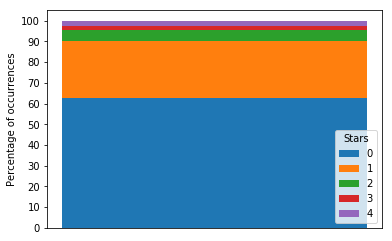

In [126]:
stacked_bar_chart(testStars, testStars_predicted_svc)

In [37]:
recall_score(testStars, testStars_predicted_svc, average='weighted')

0.6293

***

### Looking for relation between text length and rating
Tests with charts

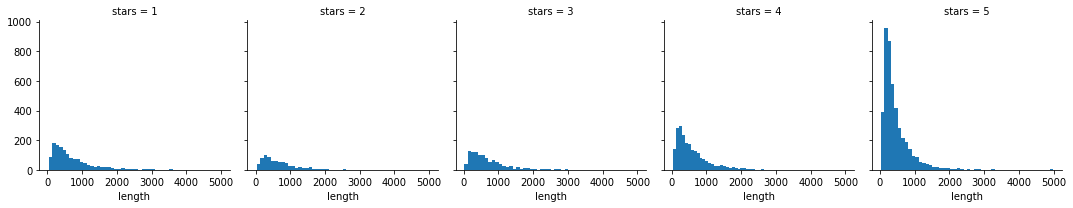

In [38]:
g = sns.FacetGrid(data=df_test, col='stars')
g.map(plt.hist, 'length', bins=50)

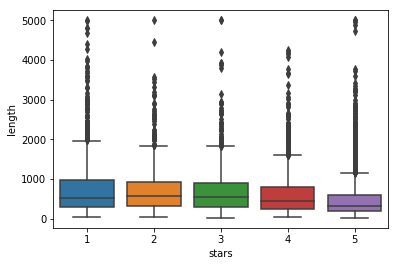

In [39]:
sns.boxplot(x='stars', y='length', data=df_test)

In [40]:
df_test.describe()

,stars,useful,funny,cool,length
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.768500,1.255300,0.426900,0.543700,587.212100
std,1.445378,2.864567,1.538601,2.083729,555.143887
min,1.000000,0.000000,0.000000,0.000000,16.000000
25%,3.000000,0.000000,0.000000,0.000000,231.000000
50%,4.000000,0.000000,0.000000,0.000000,410.000000
75%,5.000000,1.000000,0.000000,0.000000,748.000000
max,5.000000,101.000000,40.000000,94.000000,4998.000000


Training and test set have same proportions! :-)

ideas:
- make a numbers token <NUMBER>
- stem the words
- remove stopwords
- create a personal noun token <PERSONALNOUN>